In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

In [ ]:
folder_paths = [x[0] for x in os.walk('/content/drive/MyDrive/Image Processing/GAN')]

In [ ]:
folder_paths

['/content/drive/MyDrive/Image Processing/GAN',
 '/content/drive/MyDrive/Image Processing/GAN/0',
 '/content/drive/MyDrive/Image Processing/GAN/1',
 '/content/drive/MyDrive/Image Processing/GAN/2',
 '/content/drive/MyDrive/Image Processing/GAN/3',
 '/content/drive/MyDrive/Image Processing/GAN/4',
 '/content/drive/MyDrive/Image Processing/GAN/5']

In [ ]:
# Extract the artist names from the paths
artists = [os.path.basename(path).replace('_', ' ') for path in folder_paths[1:]]

# Print the list of artists
print(artists)

['0', '1', '2', '3', '4', '5']


In [ ]:
DATA_DIR = '/content/paintings/images'

if not os.path.exists(DATA_DIR):
  os.makedirs(DATA_DIR)

for folder_path in folder_paths:
  for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
      src_path = os.path.join(folder_path, filename)
      dst_path = os.path.join(DATA_DIR, filename)
      shutil.copy(src_path, dst_path)

In [ ]:
valid_extensions = ('.jpg', '.png')

# Get the list of all files in the folder with valid extensions
files = [file for file in os.listdir(DATA_DIR) if file.endswith(valid_extensions)]

# Print the total number of images in the folder
print(f'Total number of images in {DATA_DIR}: {len(files)}')

In [ ]:
print(os.listdir(DATA_DIR)[:10])

['cs1416079017964514624.jpg', 'cs13129418041517285155.jpg', 'cs11642271500921945281.jpg', 'cs2423159578819388102.jpg', 'cs13240397482063270707.jpg', 'cs16102299904276718846.jpg', 'cs3925428940012020560.jpg', 'cs2448848613852561012.jpg', 'cs13074707230251676205.jpg', 'cs12860897457959625157.jpg']


In [ ]:
folder_path = DATA_DIR

total_width = 0
total_height = 0
num_images = 0

# loop through all images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # open the image
        image = Image.open(os.path.join(folder_path, filename))

        # get the shape (dimensions) of the image
        width, height = image.size

        # accumulate the total width and height
        total_width += width
        total_height += height

        # increment the number of images
        num_images += 1

# calculate the mean dimensions
mean_width = total_width / num_images
mean_height = total_height / num_images

# print the mean dimensions
print(f"The mean dimensions of the {num_images} images are {mean_width}x{mean_height}")

The mean dimensions of the 57838 images are 500.0x500.0


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 32
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder('/content/paintings', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

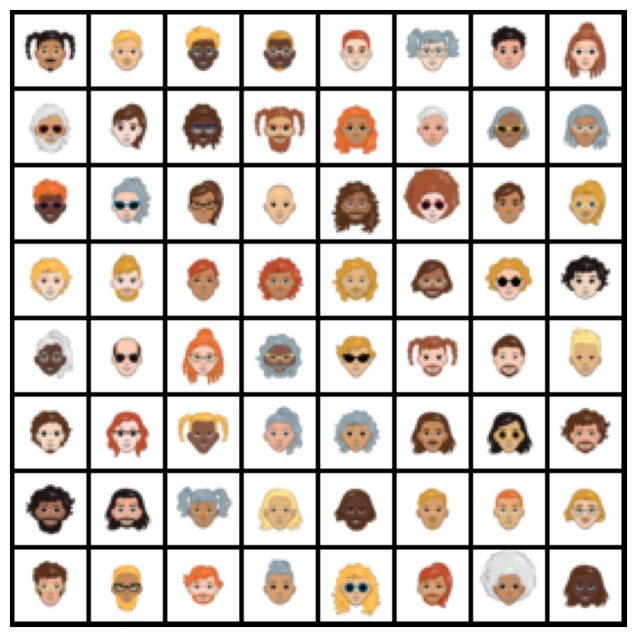

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 32 x 32

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 16 x 16

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 8 x 8

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 4 x 4

    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 4 x 4

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 8 x 8

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 16 x 16

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 32 x 32
)

torch.Size([128, 3, 32, 32])


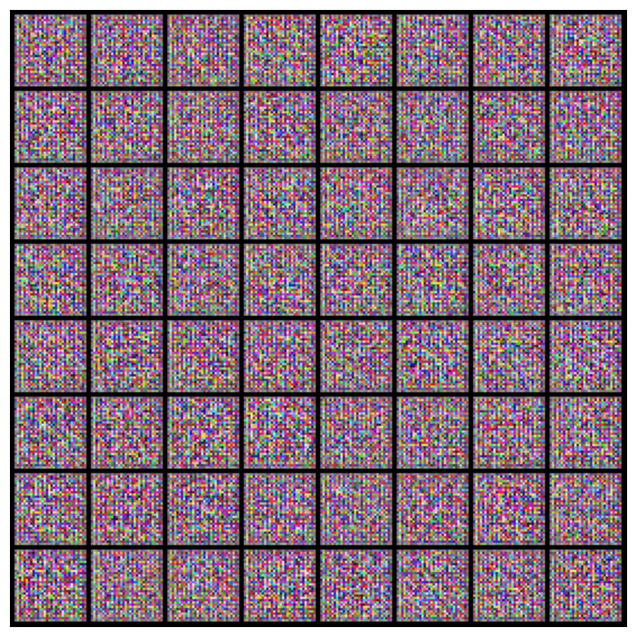

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


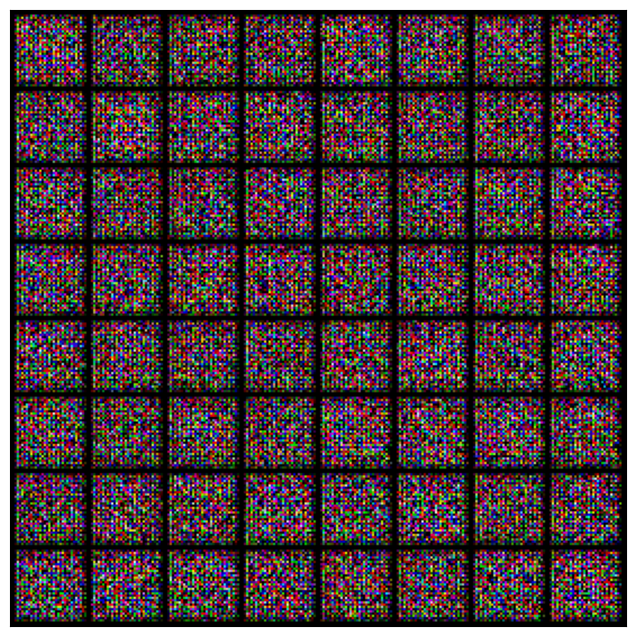

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 50

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 2.3304, loss_d: 0.3169, real_score: 0.8038, fake_score: 0.0816
Saving generated-images-0001.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 2.5811, loss_d: 1.1196, real_score: 0.3558, fake_score: 0.0039
Saving generated-images-0002.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 2.6524, loss_d: 0.1826, real_score: 0.8738, fake_score: 0.0422
Saving generated-images-0003.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 3.3816, loss_d: 0.1100, real_score: 0.9279, fake_score: 0.0320
Saving generated-images-0004.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 2.3057, loss_d: 0.4487, real_score: 0.7400, fake_score: 0.1249
Saving generated-images-0005.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 4.7392, loss_d: 0.0388, real_score: 0.9893, fake_score: 0.0272
Saving generated-images-0006.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 3.9444, loss_d: 0.0568, real_score: 0.9674, fake_score: 0.0228
Saving generated-images-0007.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 4.4882, loss_d: 0.0639, real_score: 0.9724, fake_score: 0.0342
Saving generated-images-0008.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 4.6738, loss_d: 0.0252, real_score: 0.9925, fake_score: 0.0174
Saving generated-images-0009.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 5.5085, loss_d: 0.0240, real_score: 0.9922, fake_score: 0.0158
Saving generated-images-0010.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 5.1932, loss_d: 0.0173, real_score: 0.9928, fake_score: 0.0098
Saving generated-images-0011.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 4.9486, loss_d: 0.0561, real_score: 0.9898, fake_score: 0.0440
Saving generated-images-0012.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 5.7775, loss_d: 0.0174, real_score: 0.9903, fake_score: 0.0076
Saving generated-images-0013.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 4.7418, loss_d: 0.0341, real_score: 0.9728, fake_score: 0.0046
Saving generated-images-0014.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 4.1659, loss_d: 1.2387, real_score: 0.9372, fake_score: 0.6476
Saving generated-images-0015.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 5.0435, loss_d: 0.0197, real_score: 0.9840, fake_score: 0.0034
Saving generated-images-0016.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.9105, loss_d: 0.0383, real_score: 0.9928, fake_score: 0.0300
Saving generated-images-0017.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 2.9042, loss_d: 0.6804, real_score: 0.6568, fake_score: 0.0005
Saving generated-images-0018.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 6.7141, loss_d: 0.0139, real_score: 0.9988, fake_score: 0.0125
Saving generated-images-0019.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 7.0264, loss_d: 0.0039, real_score: 0.9974, fake_score: 0.0012
Saving generated-images-0020.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 3.5438, loss_d: 0.1694, real_score: 0.9031, fake_score: 0.0573
Saving generated-images-0021.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 6.3610, loss_d: 0.0094, real_score: 0.9950, fake_score: 0.0043
Saving generated-images-0022.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 4.5564, loss_d: 0.0808, real_score: 0.9474, fake_score: 0.0250
Saving generated-images-0023.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.7806, loss_d: 0.0378, real_score: 0.9789, fake_score: 0.0157
Saving generated-images-0024.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 6.3331, loss_d: 0.0075, real_score: 0.9963, fake_score: 0.0037
Saving generated-images-0025.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 5.1254, loss_d: 0.0396, real_score: 0.9874, fake_score: 0.0260
Saving generated-images-0026.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 5.7262, loss_d: 0.0174, real_score: 0.9940, fake_score: 0.0112
Saving generated-images-0027.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 4.9180, loss_d: 0.0881, real_score: 0.9902, fake_score: 0.0730
Saving generated-images-0028.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 7.1289, loss_d: 0.0141, real_score: 0.9946, fake_score: 0.0084
Saving generated-images-0029.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 6.2108, loss_d: 0.0083, real_score: 0.9968, fake_score: 0.0050
Saving generated-images-0030.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 7.1799, loss_d: 0.0106, real_score: 0.9981, fake_score: 0.0086
Saving generated-images-0031.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.7002, loss_d: 0.0315, real_score: 0.9981, fake_score: 0.0279
Saving generated-images-0032.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 6.8201, loss_d: 0.0061, real_score: 0.9991, fake_score: 0.0051
Saving generated-images-0033.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 7.2678, loss_d: 0.0120, real_score: 0.9905, fake_score: 0.0024
Saving generated-images-0034.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 6.1645, loss_d: 0.0362, real_score: 0.9892, fake_score: 0.0241
Saving generated-images-0035.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 2.1771, loss_d: 21.4202, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0036.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 5.2080, loss_d: 0.0732, real_score: 0.9918, fake_score: 0.0604
Saving generated-images-0037.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 6.5789, loss_d: 0.0097, real_score: 0.9986, fake_score: 0.0083
Saving generated-images-0038.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 6.0502, loss_d: 0.0102, real_score: 0.9995, fake_score: 0.0095
Saving generated-images-0039.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 4.1153, loss_d: 0.0277, real_score: 0.9903, fake_score: 0.0176
Saving generated-images-0040.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 6.6172, loss_d: 0.0231, real_score: 0.9957, fake_score: 0.0184
Saving generated-images-0041.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 7.2869, loss_d: 0.0081, real_score: 0.9967, fake_score: 0.0048
Saving generated-images-0042.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 6.1520, loss_d: 0.1750, real_score: 0.9310, fake_score: 0.0482
Saving generated-images-0043.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 5.3065, loss_d: 0.0144, real_score: 0.9878, fake_score: 0.0019
Saving generated-images-0044.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.7669, loss_d: 0.0325, real_score: 0.9740, fake_score: 0.0057
Saving generated-images-0045.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 3.7353, loss_d: 0.0758, real_score: 0.9953, fake_score: 0.0661
Saving generated-images-0046.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 6.3505, loss_d: 0.0046, real_score: 0.9995, fake_score: 0.0041
Saving generated-images-0047.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 6.5131, loss_d: 0.0044, real_score: 0.9993, fake_score: 0.0036
Saving generated-images-0048.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 8.1652, loss_d: 0.0031, real_score: 0.9984, fake_score: 0.0015
Saving generated-images-0049.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 6.4365, loss_d: 0.0261, real_score: 0.9788, fake_score: 0.0039
Saving generated-images-0050.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

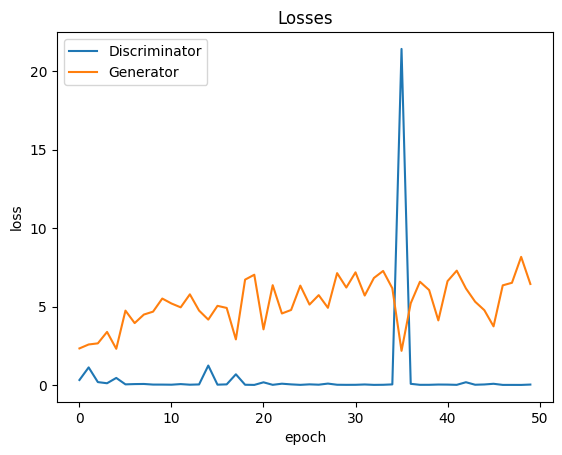

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

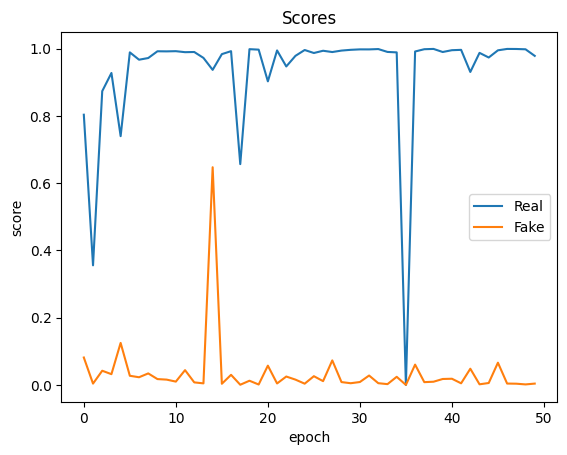

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
!zip -r /content/generated.zip /content/generated
from google.colab import files

files.download("/content/generated.zip")

  adding: content/generated/ (stored 0%)
  adding: content/generated/generated-images-0037.png (deflated 0%)
  adding: content/generated/generated-images-0017.png (deflated 0%)
  adding: content/generated/generated-images-0015.png (deflated 0%)
  adding: content/generated/generated-images-0049.png (deflated 0%)
  adding: content/generated/generated-images-0005.png (deflated 0%)
  adding: content/generated/generated-images-0029.png (deflated 0%)
  adding: content/generated/generated-images-0040.png (deflated 0%)
  adding: content/generated/generated-images-0050.png (deflated 0%)
  adding: content/generated/generated-images-0013.png (deflated 0%)
  adding: content/generated/generated-images-0039.png (deflated 0%)
  adding: content/generated/generated-images-0021.png (deflated 0%)
  adding: content/generated/generated-images-0041.png (deflated 0%)
  adding: content/generated/generated-images-0032.png (deflated 0%)
  adding: content/generated/generated-images-0031.png (deflated 0%)
  addin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/D.pth')
files.download('/content/G.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>